In [ ]:
!pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

N_exc = 8000
N_inh = 2000
p = 0.02

tau_m = 20*ms
tau_syn_exc = 5*ms
tau_syn_inh = 10*ms
E_leak = -70*mV
E_exc = 0*mV
E_inh = -80*mV
V_thr = -50*mV
V_reset = -60*mV
refractory_period = 5*ms

C_m = 200*pF
g_leak = C_m / tau_m
I_b = 200*pA
g_bar = 3*nS

w_exc_init = 0.03
w_inh_init = 0.0
w_ii = 1.0

delay_syn = 0.5*ms

neuron_eqs = '''
dv/dt = (g_leak*(E_leak - v) + I_exc + I_inh + I_b) / C_m : volt (unless refractory)
I_exc = g_exc * (E_exc - v) : amp
I_inh = g_inh * (E_inh - v) : amp
dg_exc/dt = -g_exc / tau_syn_exc : siemens
dg_inh/dt = -g_inh / tau_syn_inh : siemens
'''

start_scope()

G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset', refractory=refractory_period, method='euler')
G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset', refractory=refractory_period, method='euler')

G_exc.v = 'V_reset + rand() * (V_thr - V_reset)'
G_inh.v = 'V_reset + rand() * (V_thr - V_reset)'


S_EE = Synapses(G_exc, G_exc, 'w : 1', on_pre='g_exc_post += w*g_bar', delay=delay_syn)
S_EE.connect(p=p)
S_EE.w = w_exc_init

S_EI = Synapses(G_exc, G_inh, 'w : 1', on_pre='g_exc_post += w*g_bar', delay=delay_syn)
S_EI.connect(p=p)
S_EI.w = w_exc_init

S_IE = Synapses(G_inh, G_exc, 'w : 1', on_pre='g_inh_post += w*g_bar', delay=delay_syn)
S_IE.connect(p=p)
S_IE.w = w_inh_init


S_II = Synapses(G_inh, G_inh, 'w : 1', on_pre='g_inh_post += w*g_bar', delay=delay_syn)
S_II.connect(p=p)
S_II.w = w_ii

P_input_e = PoissonInput(G_exc, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)
P_input_i = PoissonInput(G_inh, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)


monitored_idx = 0
stat_mon = StateMonitor(G_exc, ['v', 'I_exc', 'I_inh'], record=monitored_idx)
spikes_e = SpikeMonitor(G_exc)
spikes_i = SpikeMonitor(G_inh)

run(1000*ms)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.8 MB/s eta 0:00:00


WARNING    /usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
  fig.canvas.print_figure(bytes_io, **kw)



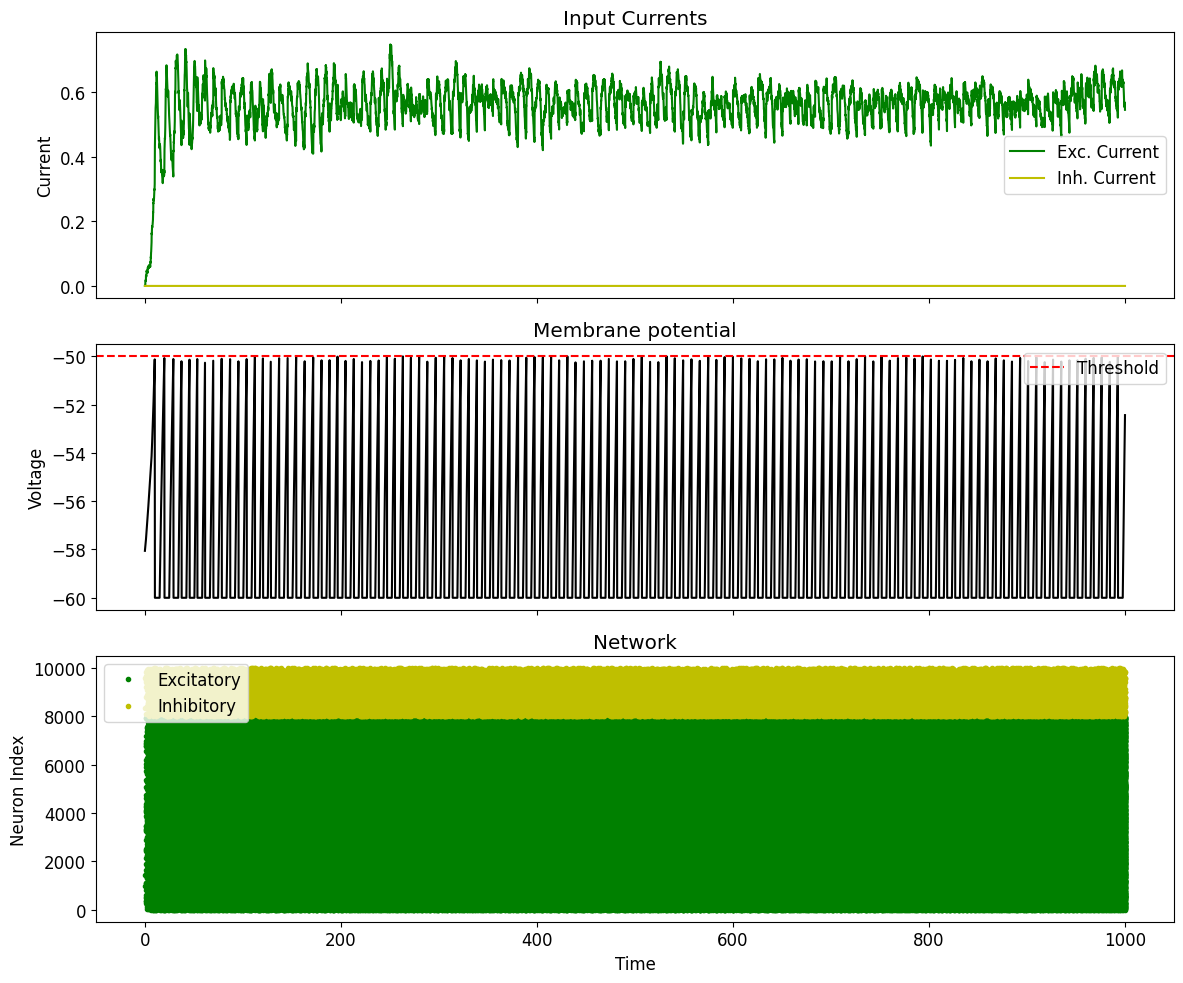

In [ ]:

defaultclock.dt = 0.1*ms
plt.rcParams.update({'font.size': 12, 'figure.figsize': [12, 10]})

t = stat_mon.t / ms
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(t, stat_mon.I_exc[0]/nA, 'g', label='Exc. Current')
ax[0].plot(t, stat_mon.I_inh[0]/nA, 'y', label='Inh. Current')
ax[0].set(ylabel='Current', title='Input Currents')
ax[0].legend()

ax[1].plot(t, stat_mon.v[0]/mV, 'k')
ax[1].axhline(V_thr/mV, color='r', linestyle='--', label='Threshold')
ax[1].set(ylabel='Voltage', title='Membrane potential')
ax[1].legend()

ax[2].plot(spikes_e.t/ms, spikes_e.i, '.g', label='Excitatory')
ax[2].plot(spikes_i.t/ms, spikes_i.i + N_exc, '.y', label='Inhibitory')
ax[2].set(xlabel='Time', ylabel='Neuron Index', title='Network')
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
def cv(spike_monitor, num_samples=100):
    cv_list = []
    trains = spike_monitor.spike_trains()
    sample_indices = np.random.choice(list(trains.keys()), size=min(num_samples, len(trains)), replace=False)

    for i in sample_indices:
        times = trains[i]
        if len(times) > 5:
            isi = np.diff(times)
            cv = np.std(isi) / np.mean(isi)
            cv_list.append(cv)

    return np.mean(cv_list) if cv_list else 0

mean_cv = cv(spikes_e)

print(f"ISI CV: {mean_cv:.4f}")

ISI CV: 0.0260


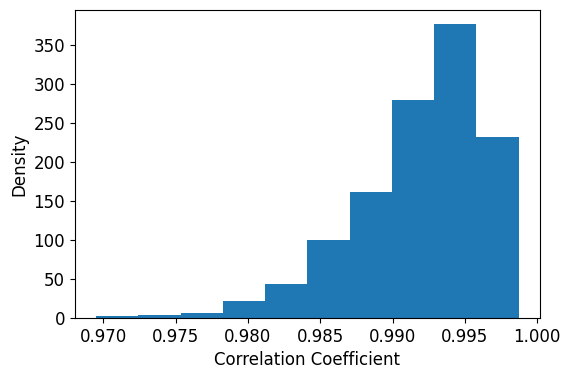

Mean Spiking Correlation: 0.9918898314127789


In [ ]:
def correlation(spike_monitor, num_neurons=50, duration=1.0):

    tau1, tau2 = 50*ms, 200*ms
    dt = 1*ms

    trains = spike_monitor.spike_trains()
    active = [i for i in trains.keys() if len(trains[i]) > 2]
    n_neurons = min(num_neurons, len(active))
    selected = np.random.choice(active, n_neurons, replace=False)

    time_bins = np.append(np.arange(0, duration, dt/second), duration)

    t_kernel = np.arange(-500, 500) * ms
    kernel = (np.exp(-np.abs(t_kernel)/tau1)/tau1 - np.exp(-np.abs(t_kernel)/tau2)/tau2)
    kernel /= np.sum(np.abs(kernel))

    filtered_signals = [np.convolve(np.histogram(trains[i], bins=time_bins)[0], kernel, mode='same') for i in selected]
    corr_matrix = np.corrcoef(filtered_signals)

    return corr_matrix[np.triu_indices(n_neurons, k=1)]

correlations = correlation(spikes_e, num_neurons=50, duration=1.0)

plt.figure(figsize=(6, 4))
plt.hist(correlations)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Density")
plt.show()

print(f"Mean Spiking Correlation: {np.mean(correlations)}")

In Part 1, the inhibitory learning rate is set to zero (η=0).

This means the inhibition is fixed or equal to zero and cannot control the excitation.
As Result the network cannot find a balance, it usually falls into one of two  states:
1- Synchronous Regular: excitation is stronger than the fixed inhibition, the neurons drive each other to fire as fast as possible in rhythmic form.

2- Silence: If the fixed inhibition were too strong, it would crush all activity, and the network would "die" with zero spikes.


The ISI CV (Coefficient of Variation) measures the "rhythm" of a single neuron. It is the best way to see how a neuron behaive.
In CV near 0 (Regular), gaps between spikes are all the same. The neuron is firing like a clock. This shows the network is unbalanced and driven by a steady, non-stop force.
CV near 1 (Irregular), gaps are random. The neuron is firing like popcorn. This proves the network is balanced because the "push" and "pull" are canceling each other out, leaving only random fluctuations to cause spikes.

We observed a Synchronous Regular (SR) state. The measures applied confirm this quantitatively: the ISI CV of 0.0263 indicates nearly perfect regularity (metronomic firing), and the Mean Spiking Correlation of 0.9914 indicates near-total global synchrony. These results match the description of an unbalanced network in Vogels et al. (2011), providing a baseline to demonstrate the stabilizing effect of inhibitory plasticity in the next step.

## Parameter

The network is composed of 10,000 neurons (8,000 excitatory and 2,000 inhibitory) characterized by a 2% random connectivity ().

### 1. Network and Neuron Parameters

* **N_exc / N_inh**: 8000 / 2000; defines the network size and population ratio.


* **p**: 0.02; the probability of connection between any two neurons.


* **V_thr**: -50 mV; the threshold potential required to trigger a spike.


* **V_reset**: -60 mV; the potential to which a neuron is reset after spiking.


* **tau_m**: 20 ms; the membrane time constant.


* **g_bar**: 3 nS; the basic unit for synaptic weight.


* **w_IE (initial)**: 0.0; the starting weight for inhibitory-to-excitatory synapses.



---

## 2. External Drive:  and Poisson Noise

To maintain network activity, two different forms of external drive are used as specified in the study:

* **Constant Background Current ()**: As detailed in Vogel artickle, $I_b=200$ pA



* **Poisson Noise Input**: Each neuron receives input from 100 external "virtual" neurons firing at **5 Hz**. This introduces the **stochastic "spark"** required for biological realism.


---

## 3. Setup for Step 2 (Plasticity)

The network currently exists in an **unbalanced state** because the initial inhibitory weights () are set to **0.0**.

* Target Firing Rate ($ρ_0=5Hz$)


* Learning Rate ($η=1×10^-2$))


* Presynaptic Offset ($α=0.2$)


In [1]:
!pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

plasticity_on = True

N_exc, N_inh = 8000, 2000
p = 0.02
tau_m, tau_syn_exc, tau_syn_inh = 20*ms, 5*ms, 10*ms
V_thr, V_reset, E_leak = -50*mV, -60*mV, -70*mV
I_b, g_bar = 200*pA, 3*nS


tau_stdp = 20*ms
eta = 1e-2 if plasticity_on else 0
alpha = 0.2
w_max = 10.0
sim_time = 100000*ms if plasticity_on else 1000*ms


neuron_eqs = '''
dv/dt = (g_leak*(E_leak - v) + I_exc + I_inh + I_b) / C_m : volt (unless refractory)
I_exc = g_exc * (0*mV - v) : amp
I_inh = g_inh * (-80*mV - v) : amp
dg_exc/dt = -g_exc / tau_syn_exc : siemens
dg_inh/dt = -g_inh / tau_syn_inh : siemens
dx/dt = -x / tau_stdp : 1  # Synaptic trace
'''
C_m = 200*pF
g_leak = C_m / tau_m

start_scope()


G_exc = NeuronGroup(N_exc, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset; x += 1', refractory=5*ms, method='euler')
G_inh = NeuronGroup(N_inh, neuron_eqs, threshold='v > V_thr',
                    reset='v = V_reset; x += 1', refractory=5*ms, method='euler')

G_exc.v = 'V_reset + rand() * (V_thr - V_reset)'
G_inh.v = 'V_reset + rand() * (V_thr - V_reset)'


S_EE = Synapses(G_exc, G_exc, 'w : 1', on_pre='g_exc_post += w*g_bar'); S_EE.connect(p=p); S_EE.w = 0.03
S_EI = Synapses(G_exc, G_inh, 'w : 1', on_pre='g_exc_post += w*g_bar'); S_EI.connect(p=p); S_EI.w = 0.03
S_II = Synapses(G_inh, G_inh, 'w : 1', on_pre='g_inh_post += w*g_bar'); S_II.connect(p=p); S_II.w = 1.0


if plasticity_on:
    pre_logic = 'g_inh_post += w*g_bar; w = clip(w + eta * (x_post - alpha), 0, w_max)'
    post_logic = 'w = clip(w + eta * x_pre, 0, w_max)'
else:
    pre_logic = 'g_inh_post += w*g_bar'
    post_logic = ''

S_IE = Synapses(G_inh, G_exc, 'w : 1', on_pre=pre_logic, on_post=post_logic)
S_IE.connect(p=p)
S_IE.w = 0.0

P_input_e = PoissonInput(G_exc, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)
P_input_i = PoissonInput(G_inh, 'g_exc', N=100, rate=5*Hz, weight=0.1*g_bar)

stat_mon = StateMonitor(G_exc, ['v', 'I_exc', 'I_inh'], record=0)
weight_mon = StateMonitor(S_IE, 'w', record=range(10))
spikes_e = SpikeMonitor(G_exc)
rate_mon = PopulationRateMonitor(G_exc)

run(sim_time)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.0 MB/s eta 0:00:00


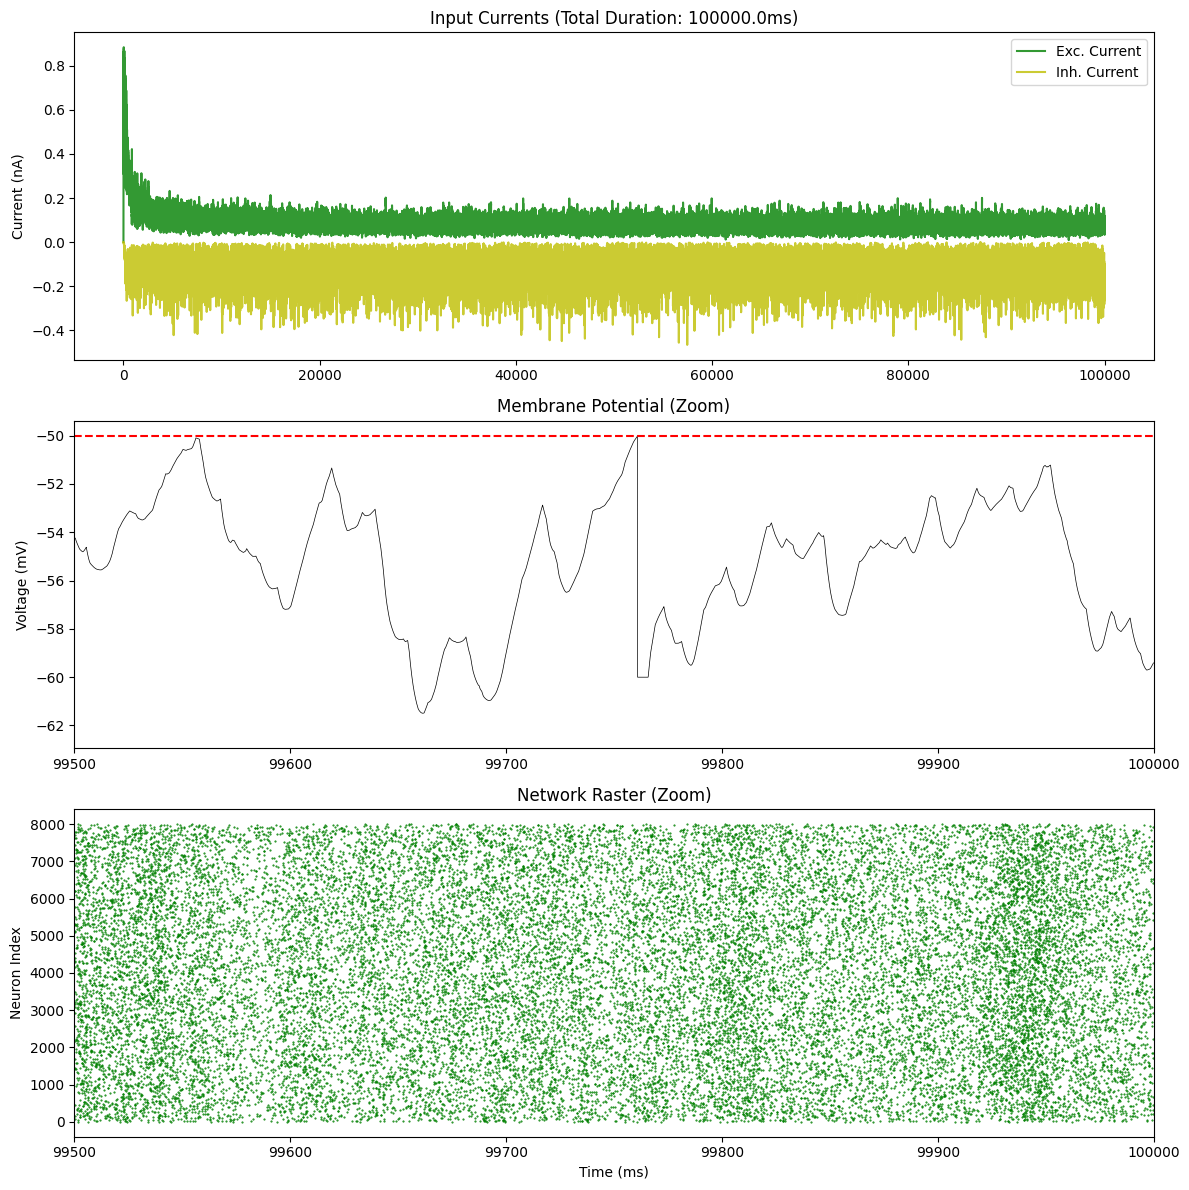

In [2]:

current_sim_time_ms = sim_time / ms
zoom_window = 500
t_start = max(0, current_sim_time_ms - zoom_window)
t_end = current_sim_time_ms

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(stat_mon.t/ms, stat_mon.I_exc[0]/nA, 'g', label='Exc. Current', alpha=0.8)
ax[0].plot(stat_mon.t/ms, stat_mon.I_inh[0]/nA, 'y', label='Inh. Current', alpha=0.8)
ax[0].set(ylabel='Current (nA)', title=f'Input Currents (Total Duration: {current_sim_time_ms}ms)')
ax[0].legend()

ax[1].plot(stat_mon.t/ms, stat_mon.v[0]/mV, 'k', linewidth=0.5)
ax[1].axhline(V_thr/mV, color='r', linestyle='--')
ax[1].set(xlim=(t_start, t_end), ylabel='Voltage (mV)', title='Membrane Potential (Zoom)')

mask = (spikes_e.t/ms > t_start)
ax[2].plot(spikes_e.t[mask]/ms, spikes_e.i[mask], '.g', markersize=1)
ax[2].set(xlim=(t_start, t_end), xlabel='Time (ms)', ylabel='Neuron Index', title='Network Raster (Zoom)')

plt.tight_layout()
plt.show()

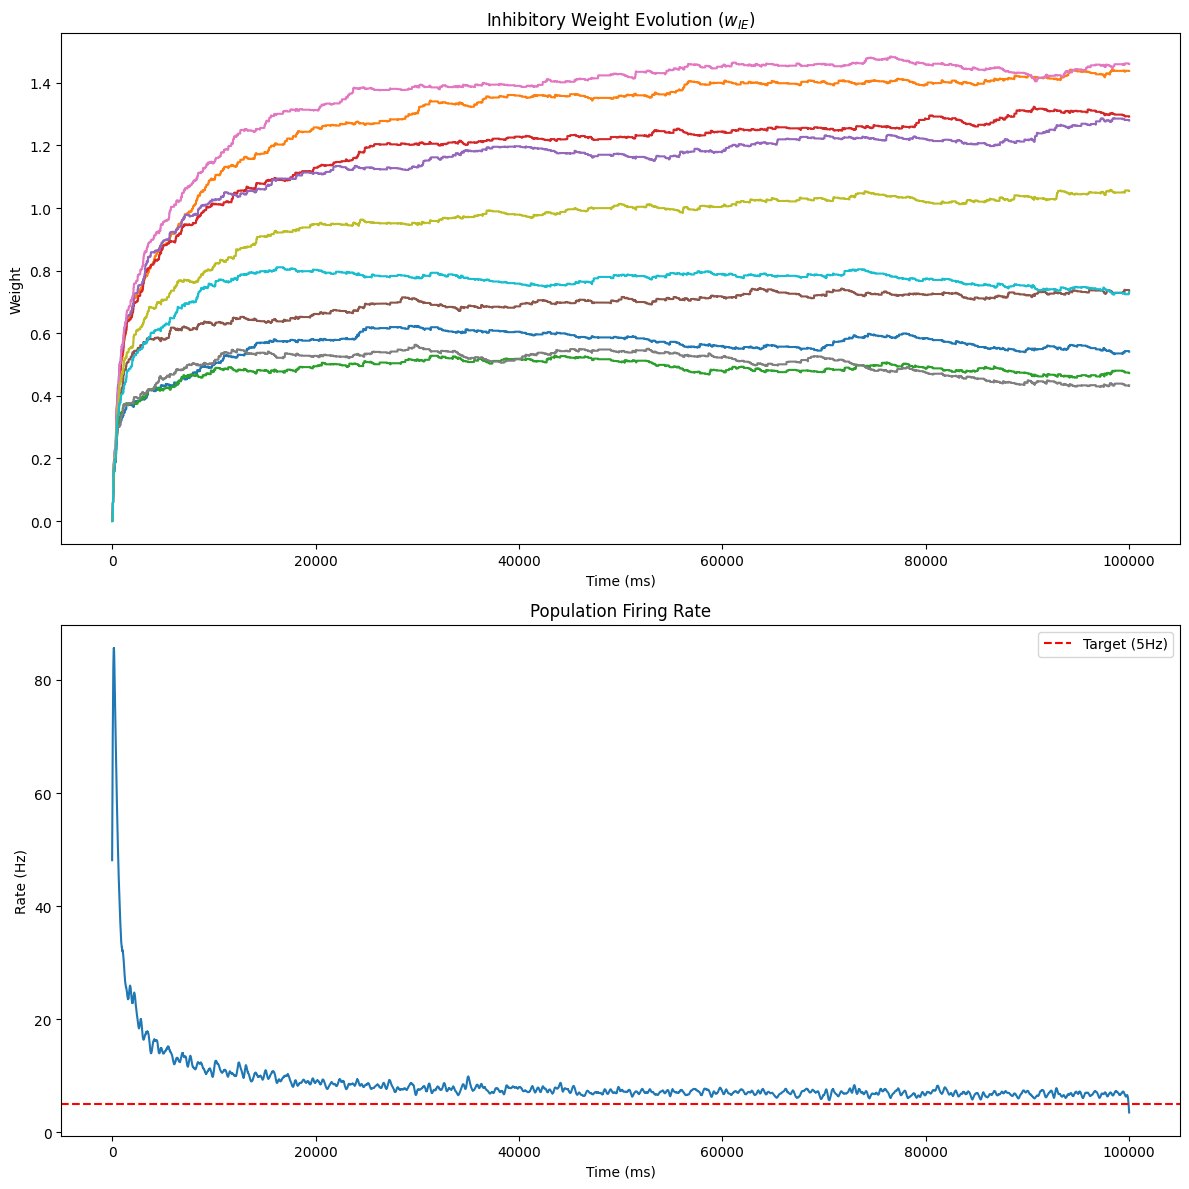

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

if 'weight_mon' in locals():
    ax[0].plot(weight_mon.t/ms, weight_mon.w.T)
ax[0].set(title="Inhibitory Weight Evolution ($w_{IE}$)", ylabel="Weight", xlabel="Time (ms)")

ax[1].plot(rate_mon.t/ms, rate_mon.smooth_rate(window='gaussian', width=100*ms)/Hz)
ax[1].axhline(5, color='r', ls='--', label='Target (5Hz)')
ax[1].set(title="Population Firing Rate", ylabel="Rate (Hz)", xlabel="Time (ms)")
ax[1].legend()

plt.tight_layout()
plt.show()

In part 2, the goal is to move the network from the bad state of part 1 into a stable. We do this by turning on inhibitory plasticity using five main parameters.

### 1. target firing rate ($\rho_0 = 5\text{hz}$)
we want the excitatory neurons to fire at an average of 5 spikes per second.
In the paper, 5 Hz is for their single-cell studies. We assumed 5 Hz for the 10,000-neuron network. It is low enough to prove that inhibition is working, also high enough to ensure the network doesn't go completely silent.

### 2. learning rate ($\eta = 1 \times 10^{-2}$)
this determines the **speed** of the weight changes. In the original paper, they used a very slow rate ($10^{-4}$), but they ran the simulation for hours. in our code, i increased this to **$1 \times 10^{-2}$**. This allows the network to find its balance in just 40 or 100 seconds instead of hours, which is necessary for google colab. it makes the "healing" process much faster.

### 3. presynaptic offset ($\alpha = 0.2$)

this is a constant used every time an inhibitory neuron spikes.
We are using the formula from the paper: $\alpha = 2 \times \rho_0 \times \tau_{stdp}$.
*  calculation: $2 \times 5\text{hz} \times 0.02\text{s} = 0.2$.

### 4. trace time constant ($\tau_{stdp} = 20\text{ms}$)
it tells the system that a pre-synaptic spike and a post-synaptic spike are only related if they happen within roughly 20ms of each other. this is a standard biological assumption for these models.

### 5. maximum weight ($w_{max} = 10.0$)
We increased this from 1.0 to **10.0**. this ensures the learning rule has enough "room" to grow the inhibition strong enough to reach the 5hz target without hitting a wall.


In part 1, unbalanced case, you see thick vertical lines.

Synchrony: The vertical lines mean that almost all 8,000 neurons are firing at the exact same time.

Regularity: The gaps between these lines are even. The network is firing like a fast regularly.

In part 2, balanced case, the vertical lines are gone. You see randomly scattered dots.

Asynchronous: The dots are not lined up. This means neurons are firing independently.

Irregular: The timing is not like a clock anymore. It looks like "snow" on an old TV or like popcorn popping.

State: This is the Asynchronous Irregular. It proves the network is balanced.


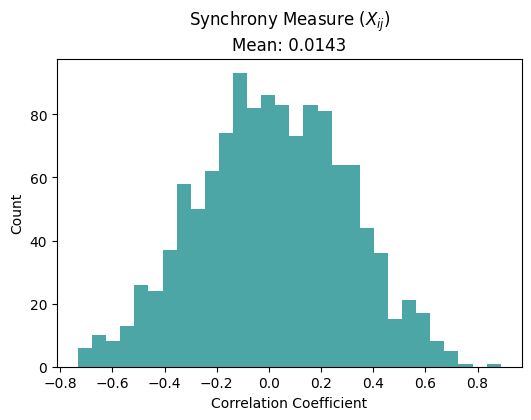

In [6]:
def calculate_vogels_correlation(spike_monitor, sim_time, num_neurons=50, window_size=1.0*second):
    t_end = sim_time
    t_start = max(0*ms, t_end - window_size)

    trains = spike_monitor.spike_trains()
    active = [i for i in trains.keys() if len(trains[i][(trains[i] >= t_start) & (trains[i] < t_end)]) > 2]

    if len(active) < 2:
        print("Warning: Not enough active neurons in the window to calculate correlation.")
        return np.array([0])

    n_neurons = min(num_neurons, len(active))
    selected = np.random.choice(active, n_neurons, replace=False)

    dt = 1*ms
    tau1, tau2 = 50*ms, 200*ms
    t_kernel = np.arange(-500, 500) * ms
    kernel = (np.exp(-np.abs(t_kernel)/tau1)/tau1 - np.exp(-np.abs(t_kernel)/tau2)/tau2)
    kernel /= np.sum(np.abs(kernel))

    bins = np.arange(t_start/ms, t_end/ms + dt/ms, dt/ms)

    filtered_signals = []
    for i in selected:
        spikes_in_window = trains[i][(trains[i] >= t_start) & (trains[i] < t_end)]
        binned_spikes, _ = np.histogram(spikes_in_window/ms, bins=bins)
        filtered_signals.append(np.convolve(binned_spikes, kernel, mode='same'))

    corr_matrix = np.corrcoef(filtered_signals)
    correlations = corr_matrix[np.triu_indices(n_neurons, k=1)]

    return correlations

corrs = calculate_vogels_correlation(spikes_e, sim_time=sim_time)

plt.figure(figsize=(6, 4))
plt.hist(corrs, bins=30, color='teal', alpha=0.7)
plt.title(f"Synchrony Measure ($X_{{ij}}$)\nMean: {np.mean(corrs):.4f}")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.show()

While in part 1 mean correlation was almost 1, in this histogram, the mean correlation is 0.0143. This is a very small number, almost zero.
It means the neurons are now firing independently. The chart is centered around zero, which proves the network is now Asynchronous.The inhibitory plasticity has successfully pushed the network into the Asynchronous Irregular state.
